<div style="display: flex; align-items: center; padding: 20px; background-color: #f0f2f6; border-radius: 10px; border: 2px solid #007bff;">
    <img src="../logo.png" style="width: 80px; height: auto; margin-right: 20px;">
    <div style="flex: 1; text-align: left;">
    <h1 style="color: #007bff; margin-bottom: 5px;">GLY 6739.017S26: Computational Seismology</h1>
    <h3 style="color: #666;">Notebook 09: Instrument Responses (Plotting only)</h3>
    <p style="color: red;"><i>Glenn Thompson | Spring 2026</i></p>
    </div>
</div>

This notebook downloads **nominal** instrument responses from the **EarthScope/IRIS Nominal Response Library (NRL)** for a Nanometrics Trillium & Centaur combination, using ObsPy, and then shows:

1) **Sensor response** (frequency-domain + time-domain equivalent filter)  
2) **Digitizer response** (frequency-domain + time-domain equivalent filter)  
3) **Combined response** (frequency-domain + time-domain equivalent filter)

It also shows the response of a Raspberry Shake seismometer.

Notes:
- Frequency-domain plots use ObsPy's built-in `Inventory.plot_response()` (robust across versions).

## Setup

You need ObsPy + NumPy + Matplotlib. For conda:

```bash
conda install -c conda-forge obspy numpy matplotlib
```

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from obspy.clients.nrl import NRL
from obspy.core.inventory import Inventory, Network, Station, Channel, Site
from obspy import UTCDateTime

## 1) Download responses from the NRL

We use two approaches:

- **Combined response**: public API  
  `nrl.get_response(datalogger_keys=..., sensor_keys=...)`

- **Sensor-only / Digitizer-only**: internal helper (simplest way to get them separately)  
  `nrl._get_response("sensors", keys=...)` and `nrl._get_response("dataloggers", keys=...)`

In many ObsPy builds, `_get_response()` returns a `Response` object directly. This notebook handles either return type.

In [21]:
nrl = NRL()

sensor_keys = ["Nanometrics", "Trillium Compact 120 (Vault, Posthole, OBS)", "754 V/m/s"]
datalogger_keys = ["Nanometrics", "Centaur", "40 Vpp (1)", "Off", "Linear phase", "100"]

# Combined response (public API)
resp_combined = nrl.get_response(datalogger_keys=datalogger_keys, sensor_keys=sensor_keys)

# Sensor-only / Digitizer-only (helper)
sensor_obj, _ = nrl._get_response("sensors", keys=sensor_keys)
dl_obj, _     = nrl._get_response("dataloggers", keys=datalogger_keys)

def to_response(obj):
    if obj.__class__.__name__ == "Response":
        return obj
    return obj[0][0][0].response  # Inventory -> net -> sta -> cha -> response

resp_sensor = to_response(sensor_obj)
resp_digitizer = to_response(dl_obj)


/var/folders/4q/5426zn1d72vgcb6h658n_8800000gn/T/ipykernel_62736/2421611632.py:1: ObsPyDeprecationWarning: 
        DEPRECATED

        Direct access to online NRL is deprecated as it will stop working when
        the original NRLv1 gets taken offline (Spring 2023), please consider
        working locally with a downloaded full copy of the old NRLv1 or new
        NRLv2 following instructions on the
        `NRL landing page <https://ds.iris.edu/ds/nrl/>`_.
        
  nrl = NRL()


## 2) Wrap each `Response` in an `Inventory`

`Inventory.plot_response()` is the most robust way to plot response magnitude/phase, and it expects an Inventory/Channel.
So we build a tiny "dummy" Inventory for each response.

In [22]:
def response_to_inventory(resp, net="XX", sta="NRL1", loc="00", cha="HHZ", sr=100.0):
    neto = Network(code=net)
    stao = Station(
        code=sta,
        latitude=0, longitude=0, elevation=0,
        creation_date=UTCDateTime(2020, 1, 1),
        site=Site(name="NRL")
    )
    chao = Channel(
        code=cha,
        location_code=loc,
        latitude=0, longitude=0,
        elevation=0, depth=0,
        azimuth=0, dip=-90,
        sample_rate=sr
    )
    chao.response = resp
    stao.channels.append(chao)
    neto.stations.append(stao)
    return Inventory(networks=[neto], source="NRL via ObsPy")

inv_sensor    = response_to_inventory(resp_sensor,    sta="SENSOR",   sr=100.0)
inv_digitizer = response_to_inventory(resp_digitizer, sta="DIGI",     sr=100.0)
inv_combined  = response_to_inventory(resp_combined,  sta="COMBINED", sr=100.0)

## 3) Frequency-domain response plots (magnitude + phase)

We plot with `output="VEL"` to match your combined response, which is:

**From M/S (ground velocity) to COUNTS**

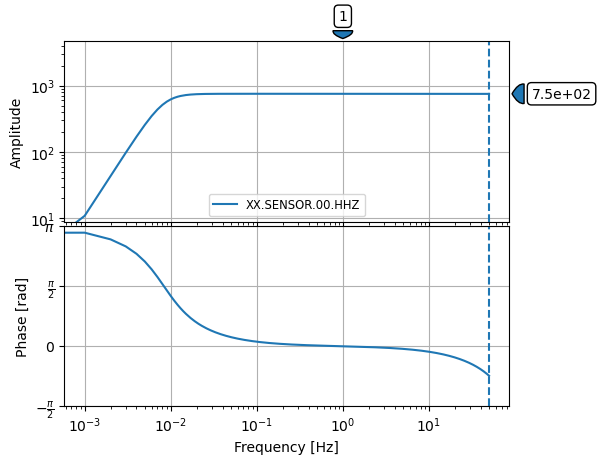

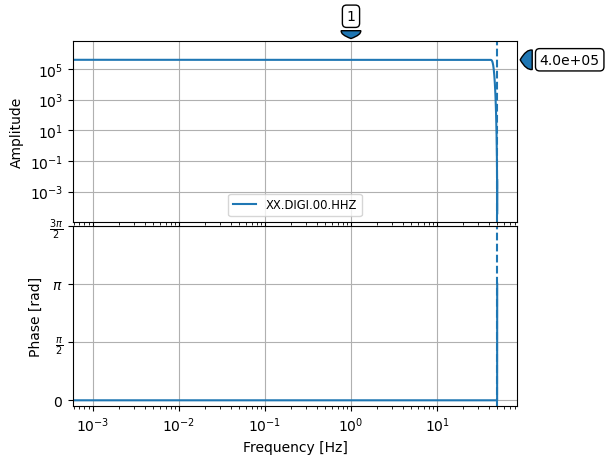

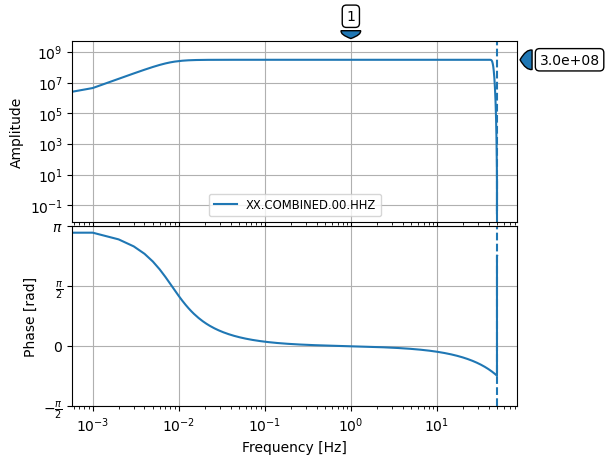

In [23]:
inv_sensor.plot_response(min_freq=0.001, output="VEL");
inv_digitizer.plot_response(min_freq=0.001, output="VEL");
inv_combined.plot_response(min_freq=0.001, output="VEL");

## 4) (Optional) Print response stages

Useful for teaching how a real response is a *cascade* of stages (PAZ + coefficient/FIR stages).

In [24]:
def list_stages(resp, name=""):
    print(f"\n{name}")
    print(resp)
    for i, stg in enumerate(resp.response_stages, start=1):
        gain = getattr(stg, "stage_gain", None)
        print(f"  Stage {i}: {type(stg).__name__}  gain={gain}")
    print(' ')

list_stages(resp_sensor, "Sensor-only stages")
list_stages(resp_digitizer, "Digitizer-only stages")
list_stages(resp_combined, "Combined stages")


Sensor-only stages
Channel Response
	From M/S (Velocity in Meters per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 754.3 defined at 1.000 Hz
	2 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 754.3
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 1
  Stage 1: PolesZerosResponseStage  gain=754.3
  Stage 2: CoefficientsTypeResponseStage  gain=1.0
 

Digitizer-only stages
Channel Response
	From M/S (Velocity in Meters per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 400000 defined at 1.000 Hz
	6 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 1
		Stage 2: PolesZerosResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 400000
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
  Stage 1: PolesZerosResponseStage 

## Choose a Raspberry Shake, and download & plot the response

RCD29 is one of my Raspberry Shake & Boom instruments.
* Shake: a geophone (high-frequency short-period seismometer, peaks at 4.5 Hz)
* Boom: an infrasound sensor

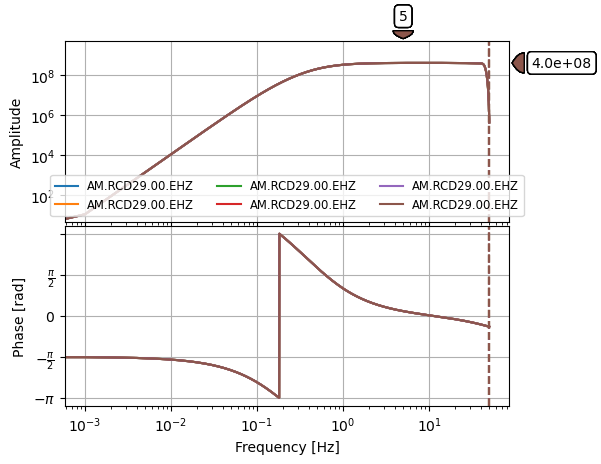

Stage 1: PolesZerosResponseStage, gain=399650000.0
Stage 2: CoefficientsTypeResponseStage, gain=1.0
Stage 3: FIRResponseStage, gain=1.0


In [25]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

rs = Client("RASPISHAKE")  # or Client("https://data.raspberryshake.org")
inv = rs.get_stations(network="AM", station="RCD29", channel='EHZ', level="response")
inv.plot_response(min_freq=0.001, output="VEL");

net = inv.select(network="AM", station="RCD29", channel="EHZ")[0]
sta = net.stations[0]
cha = sta.channels[0]
resp = cha.response
for i, stage in enumerate(resp.response_stages, start=1):
    print(f"Stage {i}: {type(stage).__name__}, gain={getattr(stage, 'stage_gain', None)}")

